### Diagnositics for a flock of particels

When a group of particles, or trajectories, join together is space, they can be considered a ''flock''. Such clusters have specific diagnostics and spatial temporal statistics, of which some are shown below. 

### 0. Import of libraries

General libraries are imported, but also the specific functions which are situated in this folder


In [10]:
import xarray as xr
import cartopy
import matplotlib.pyplot as plt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import numpy as np
from osgeo import osr

### 1. Load the data
load the toy data:

In [4]:
file = '../../Simulations/toy_data_01.nc'

ds=xr.open_dataset(file)
lat, lon = ds['lat'][:], ds['lon'][:]
tim, id = ds['time'][:], ds['trajectory'][:]

### 2. Calculate flock properties

The toy data example consist of parcels that are released at the same time, within an square box. As time progresses these parcels create trajectories. One trajectory which might describe the general trajectory best is the [medoid](https://en.wikipedia.org/wiki/Medoid). In respect to all others, this spatial temporal path has the least separation distance, along the whole timespan. It can be calculated in the following way:

In [11]:

def dist_meter(lon_1, lon_2, lat_1, lat_2, radius=None):
    """ calculate the distance between two locations
    """
    Δlon, Δlat = lon_2 - lon_1, lat_2 - lat_1
    lat_mean = (lat_1+lat_2)/2

    distance = haversine(Δlat, Δlon, lat_mean, radius=radius)
    return distance

def haversine(Δlat, Δlon, lat, radius=None):
    """ calculate the distance along a great-circle

    Parameters
    ----------
    Δlat, Δlon : float, unit=degrees
        step size or angle difference
    lat : float, unit=degrees
        (mean) latitude where angles are situated
    radius : float, unit=meters
        estimate of the radius of the earth

    Returns
    -------
    float, unit=meters
        distance
    """
    Δlat, Δlon, lat = np.deg2rad(Δlat), np.deg2rad(Δlon), np.deg2rad(lat)

    if radius is None:
        wgs84 = osr.SpatialReference()
        wgs84.ImportFromEPSG(4326)
        a,b = wgs84.GetSemiMajor(), wgs84.GetSemiMinor()
        radius = np.sqrt(np.divide((a**2*np.cos(lat))**2 +
                                   (b**2*np.sin(lat))**2,
                                   (a*np.cos(lat))**2 + (b*np.sin(lat))**2)
                         )

    a = np.sin(Δlat / 2) ** 2 + \
        np.cos(lat) * np.cos(lat+Δlat) * np.sin(Δlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)) # great circle distance
    d = radius * c
    return d

In [12]:
def mediod(X, Y, spherical=False, robust=True):
    """ calculate which trajectory with least disagreement with all others

    Parameters
    ----------
    X,Y: np.ndarray, size=(m,n), unit={degrees,meters}
        m: individual entity, n: time
    spherical: bool
        when True, then spherical coordinates are given
        otherwise metric plane coordinates are assumed
    robust: bool
        when True, robust statistics are used in the form of the median
        otherwise the mean is used instead

    Returns
    -------
    integer, range=0...m
        index of the trajectory with the least sepration distance between
        all other trajectories
    """
    assert len(set({X.size, Y.size})) == 1
    assert len(set({X.ndim, Y.ndim})) == 1

    X, Y = np.atleast_2d(X), np.atleast_2d(Y)
    m,n = X.shape[:2]
    err = np.zeros((m,))
    for i in range(n):
        X_A, X_B = np.meshgrid(X[:, i], X[:, i])
        Y_A, Y_B = np.meshgrid(Y[:, i], Y[:, i])
        if spherical:
            D = dist_meter(X_A, X_B, Y_A, Y_B)
        else:
            D = np.sqrt((X_A - X_B)**2 + (Y_A - Y_B)**2)
        if robust:
            err += np.median(D, axis=1)
        else:
            err += np.mean(D, axis=1)
    id = np.argmin(err)
    return id


In [13]:
id = mediod(lon.data, lat.data, spherical=True)

/opt/anaconda3/envs/heterogen/lib/python3.13/site-packages/osgeo/osr.py:424: FutureWarning: Neither osr.UseExceptions() nor osr.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


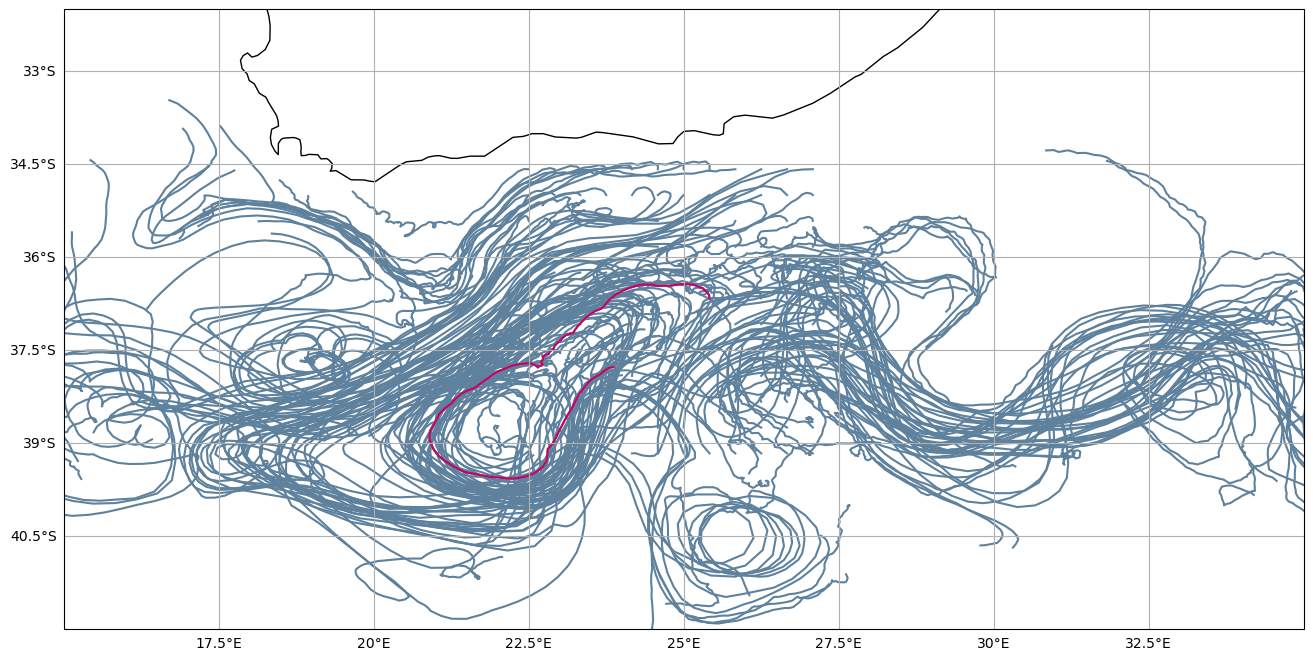

In [14]:
fig = plt.figure(figsize=(16,17)) #(17,5)
ax1 = plt.subplot(111, projection=cartopy.crs.PlateCarree())
    
ax1.coastlines(resolution='50m')
ax1.plot(lon.data.T, lat.data.T, transform=cartopy.crs.PlateCarree(), color='xkcd:greyish blue')
ax1.plot(lon.data[id,...], lat.data[id,...], transform=cartopy.crs.PlateCarree(), color='xkcd:deep pink')
ax1.set_xlim([15, 35])
ax1.set_ylim([-42, -32])
gl = ax1.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=True)
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

plt.show()

## Center of mass displacement

In [15]:
def center_of_mass_displacement(X, Y, X0=None, Y0=None):
    """ see equation (1) in [La08]_.

    Parameters
    ----------
    X,Y: numpy.ndarray, size=(m,n), unit={degrees,meters}
        m: id, n: time
    X0,Y0: {float, numpy.ndarray}
        initial coordinate(s) at the start

    Returns
    -------
    M_x,M_y: np.ndarray, size=(n,), unit={degrees,meters}
        displacement of the center of mass over time for the different axis

    See Also
    --------
    center_of_mass_spread

    References
    ----------
    .. [La08] LaCasce, "Statistics from Lagrangian observations", Progress in
              Oceanography, vol.77(1) pp.1-29, 2008.
    """
    assert len(set({X.size, Y.size})) == 1
    assert len(set({X.ndim, Y.ndim})) == 1

    X,Y = np.atleast_2d(X), np.atleast_2d(Y)
    if X0 is None:
        X0,Y0 = X[:,0], Y[:,0]

    M_x,M_y = np.mean(np.transpose(X.T-X0), axis=0), \
              np.mean(np.transpose(Y.T-Y0), axis=0)
    return M_x,M_y

In [16]:
dispx, dispy = center_of_mass_displacement(lon.data, lat.data)
a = np.mean(lon.data[:,0]) +dispx
b = np.mean(lat.data[:,0]) + dispy

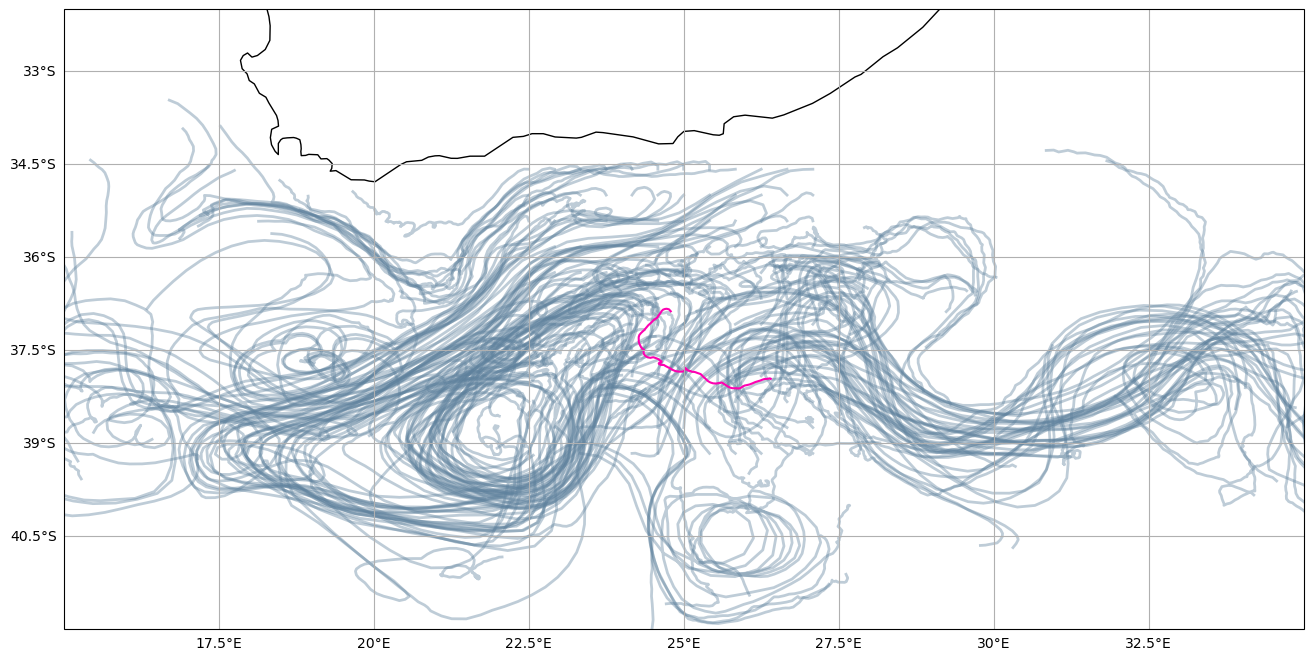

In [17]:
fig = plt.figure(figsize=(16,17)) #(17,5)
ax1 = plt.subplot(111, projection=cartopy.crs.PlateCarree())
    
ax1.coastlines(resolution='50m')
ax1.plot(lon.data.T, lat.data.T, transform=cartopy.crs.PlateCarree(), 
         color='xkcd:greyish blue', alpha=0.4, linewidth=2)
ax1.plot(a, b, 
         transform=cartopy.crs.PlateCarree(), color='xkcd:bright pink')
ax1.set_xlim([15, 35])
ax1.set_ylim([-42, -32])
gl = ax1.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=True)
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

plt.show()

## Center of mass dispersion

In [20]:
def center_of_mass_spread(X, Y, X0=None, Y0=None, M_x=None, M_y=None):
    """ see equation (2) in [La08]_.

    Parameters
    ----------
    X,Y: numpy.ndarray, size=(m,n), unit={degrees,meters}
        m: id, n: time
    X0,Y0: {float, numpy.ndarray}
        initial coordinate(s) at the start
    Mx,My: numpy.ndarray, size=(n,)
        first moment of the flock

    Returns
    -------
    D_x,D_y: numpy.ndarray, size=(n,), unit={degrees,meters}
        spread of the center of mass over time for the different spatial axis

    See Also
    --------
    center_of_mass_displacement

    References
    ----------
    .. [La08] LaCasce, "Statistics from Lagrangian observations", Progress in
              Oceanography, vol.77(1) pp.1-29, 2008.
    """
    assert len(set({X.size, Y.size})) == 1
    assert len(set({X.ndim, Y.ndim})) == 1

    X,Y = np.atleast_2d(X), np.atleast_2d(Y)
    if X0 is None:
        X0,Y0 = X[:,0], Y[:,0]
    if M_x is None:
        M_x,M_y = center_of_mass_displacement(X, Y, X0=X0, Y0=Y0)

    def _estimate_dispersion(Z, Z0, M_z):
        m, n = Z.shape[:2]
        D_z = np.sum(np.power( Z \
                               - np.tile(np.atleast_2d(Z0).T,(1, n)) \
                               - np.tile(np.atleast_2d(M_z), (m, 1)),2),
                     axis=0) / (n-1)
        return D_z

    D_x = _estimate_dispersion(X, X0, M_x)
    D_y = _estimate_dispersion(Y, Y0, M_y)
    return D_x, D_y

In [21]:
D_lat, D_lon = center_of_mass_spread(lon.data, lat.data, M_x=dispx, M_y=dispy)

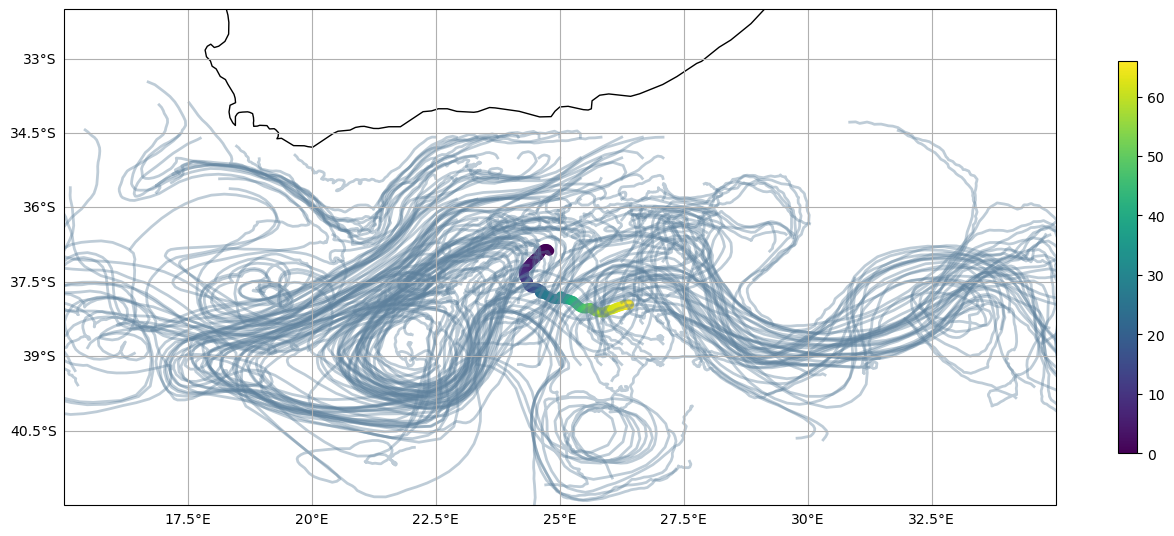

In [24]:
fig = plt.figure(figsize=(16,17)) #(17,5)
ax1 = plt.subplot(111, projection=cartopy.crs.PlateCarree())
    
ax1.coastlines(resolution='50m')
ax1.plot(lon.data.T, lat.data.T, transform=cartopy.crs.PlateCarree(), 
         color='xkcd:greyish blue', alpha=0.4, linewidth=2)
cc = ax1.scatter(a, b,
                 transform=cartopy.crs.PlateCarree(), c=np.sqrt(D_lat**2 + D_lon**2))
ax1.set_xlim([15, 35])
ax1.set_ylim([-42, -32])
gl = ax1.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=True)
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
plt.colorbar(cc, shrink=0.3)
plt.show()

## Cumulative Separation

In [25]:
def normalized_cumulative_lagrangian_separation(X, Y, X_ref=None, Y_ref=None,
                                                leader_id=None, spherical=True):
    """ eq. (3) in [LW11]_

    Parameters
    ----------
    X,Y: numpy.ndarray, size=(m,n), unit={degrees,meters}
        trajectery stack with m: id, n: time
    X_ref,Y_ref: numpy.ndarray, size=(n,)
        reference or leader trajectory
    leader_id: integer, range=0...m
        index of the leader within the trajectery stack {X,Y}
    spherical: bool
        when True, then spherical coordinates are given
        otherwise metric plane coordinates are assumed

    Returns
    -------
    numpy.ndarray, size=(m,), unit=meters
        skill score for the different tracks in respect to the leader/reference

    References
    ----------
    .. [LW11] Liu & Weisberg, "Evaluation of trajectory modeling in different
              dynamic regions using normalized cumulative Lagrangian separation"
              Journal of geophysical research, vol.116 pp.C09013, 2011.
    """

    if leader_id is not None:
        X_ref, Y_ref = X[leader_id,:], Y[leader_id,:]
        X, Y = np.delete(X, leader_id, axis=0), np.delete(Y, leader_id, axis=0)

    if spherical:
        D = dist_meter(X_ref, X, Y_ref, Y) # distance from target
        L = dist_meter(X[:,:-1], X[:,1:], Y[:,:-1], Y[:,1:]) # travel distance
    else:
        D = np.sqrt(np.power(X - X_ref, 2) + np.power(Y - Y_ref, 2))
        L = np.sqrt(np.power(X[:,:-1] - X[:,1:], 2) +
                    np.power(Y[:,:-1] - Y[:,1:], 2))
    L = np.c_[np.zeros((L.shape[0],1)), L]
    L_cum = np.cumsum(L, axis=1)

    c = np.divide(np.sum(D, axis=1), np.sum(L_cum, axis=1))
    return c

In [26]:
c = normalized_cumulative_lagrangian_separation(lon.data, lat.data,
                                                leader_id=id, spherical=True)

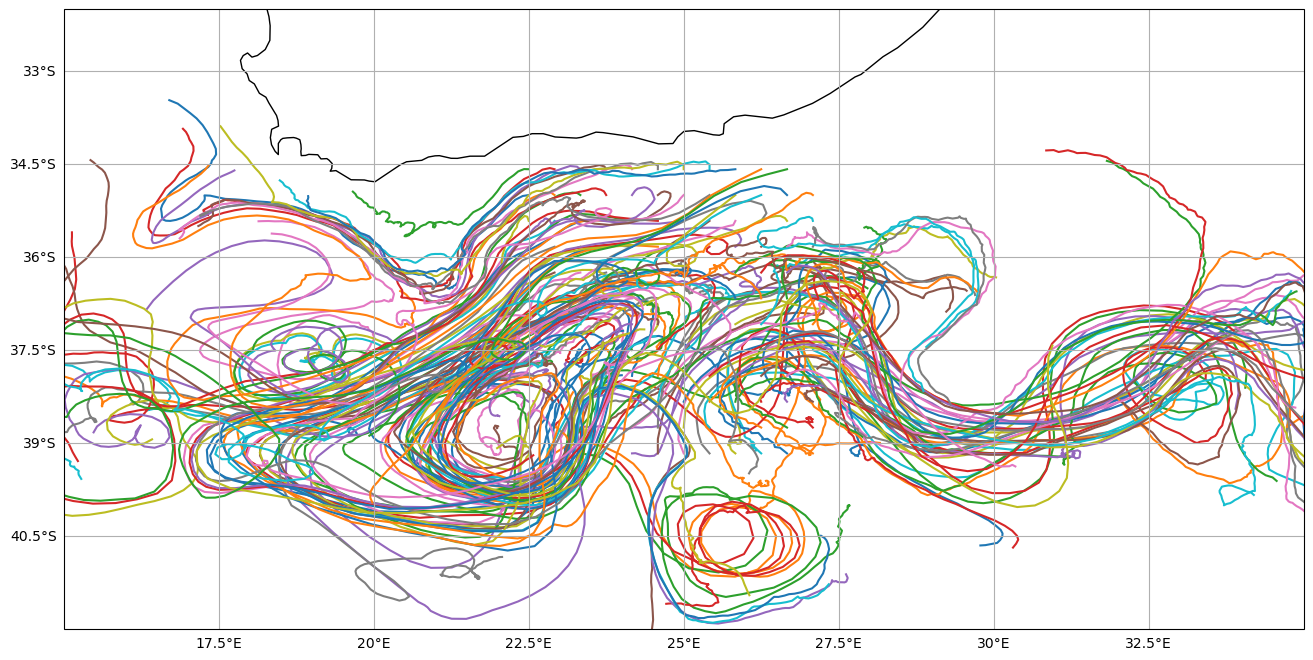

In [33]:
fig = plt.figure(figsize=(16,17)) #(17,5)
ax1 = plt.subplot(111, projection=cartopy.crs.PlateCarree())
    
ax1.coastlines(resolution='50m')
for i in range(lat.shape[0]-1):
    ax1.plot(lon.data[i,:], lat.data[i,:], 
             )
ax1.set_xlim([15, 35])
ax1.set_ylim([-42, -32])
gl = ax1.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=True)
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

plt.show()